# Project 1: Orientation Tracking
ECE276A Sensing and Estimation in Robotics\
\
Zejia Wu zew024@ucsd.edu

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time
import numpy as np
import transforms3d as t3d
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import jit, grad, vmap
from scipy.spatial.transform import Rotation as R

# from rotplot import rotplot
from load_data import tic, toc, read_data
from imu_calibration import raw2physical
from motion import rot_integrate, motion_loss, q2euler
from observation import acc_body_frame, observation_loss
from optimization import optimize
from visualization import plot_imu, acc_rpy_plot, vicon_roll_pitch_yaw, roll_pitch_yaw_plot, loss_plot
from panorama import process_cam, images2pc, plot_cylinder


## Data Loading

In [2]:
dataset = "1"
dataset_type = "trainset"
ifile = f"../data/{dataset_type}/imu/imuRaw{dataset}.p"
vfile = f"../data/{dataset_type}/vicon/viconRot{dataset}.p"
cfile = f"../data/{dataset_type}/cam/cam{dataset}.p"

ts = tic()
imu_raw = read_data(ifile)
start_time = imu_raw[0, 0]
print(f"IMU Start time: {start_time}")
if dataset_type == "trainset":
    vicon_rot = read_data(vfile)
    print(f"Vicon Start time: {vicon_rot["ts"][0, 0]}")
toc(ts, "Read data")

IMU Start time: 1296636783.735697
Vicon Start time: 1296636783.574389
Read data took: 0.0038111209869384766 sec.



## IMU Calibration

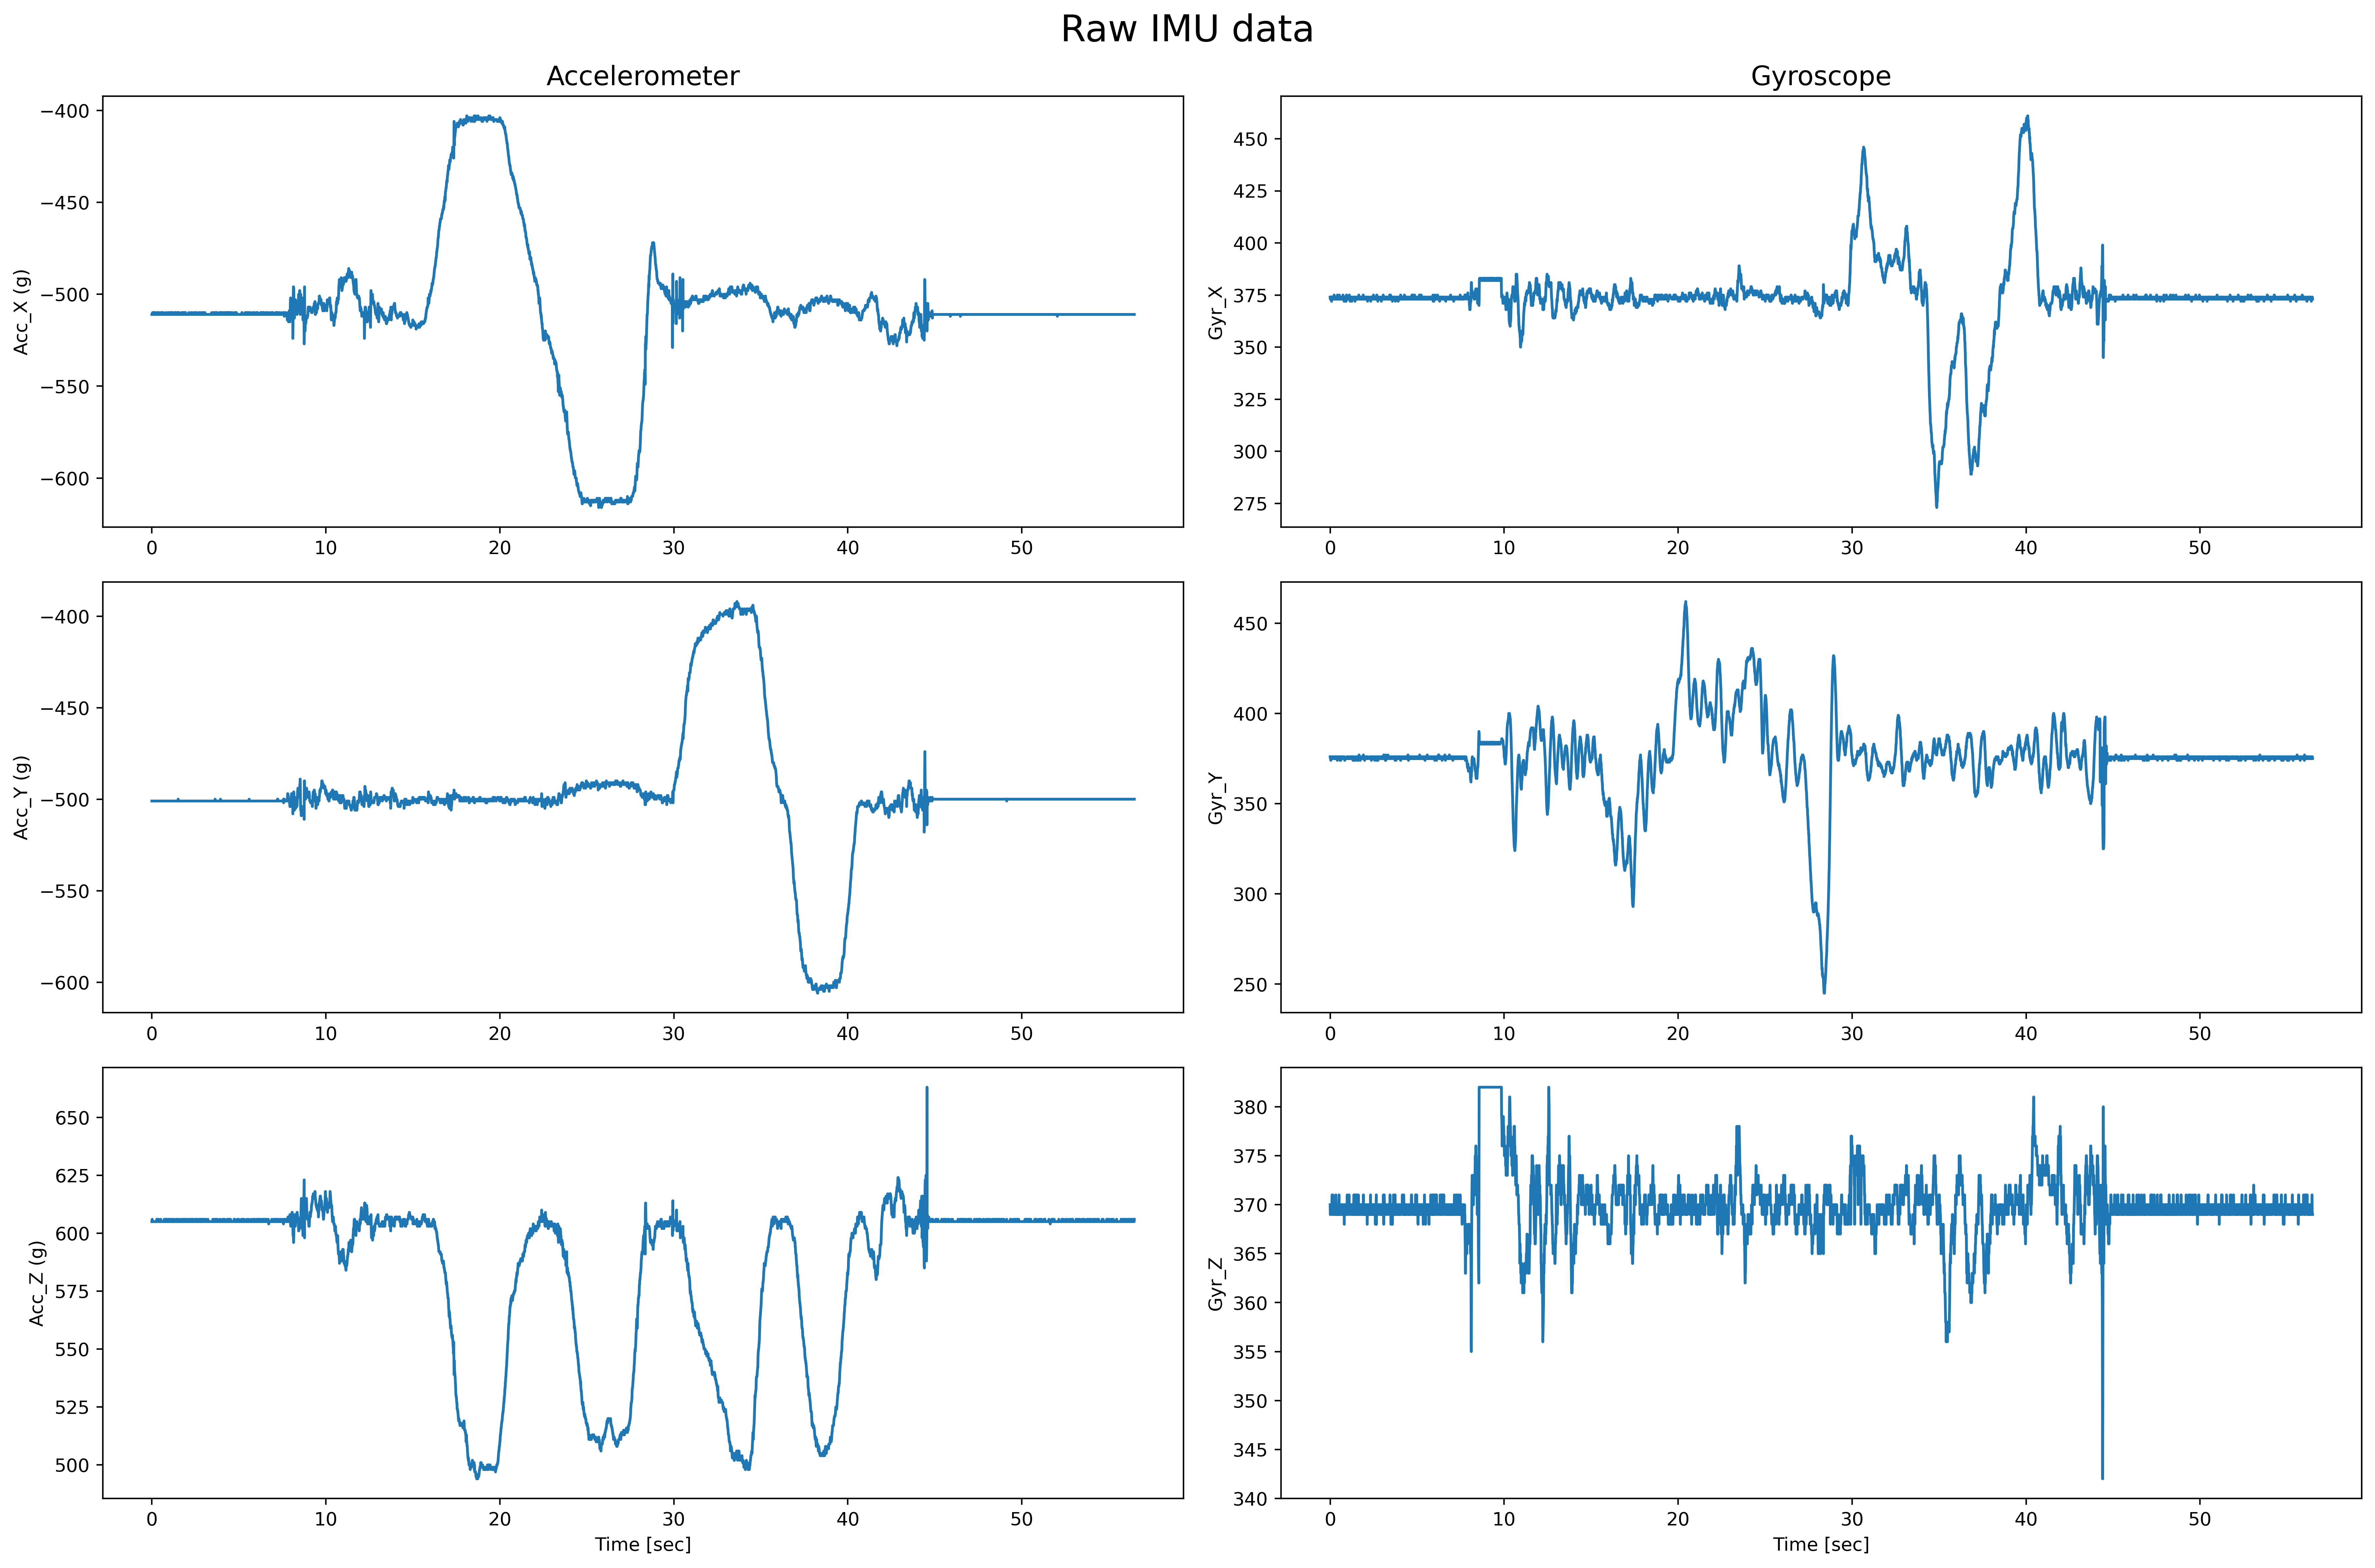

Estimated bias: x=-510.7900, y=-501.0000, z=512.1300, gx=373.6300, gy=375.2000, gz=369.6600


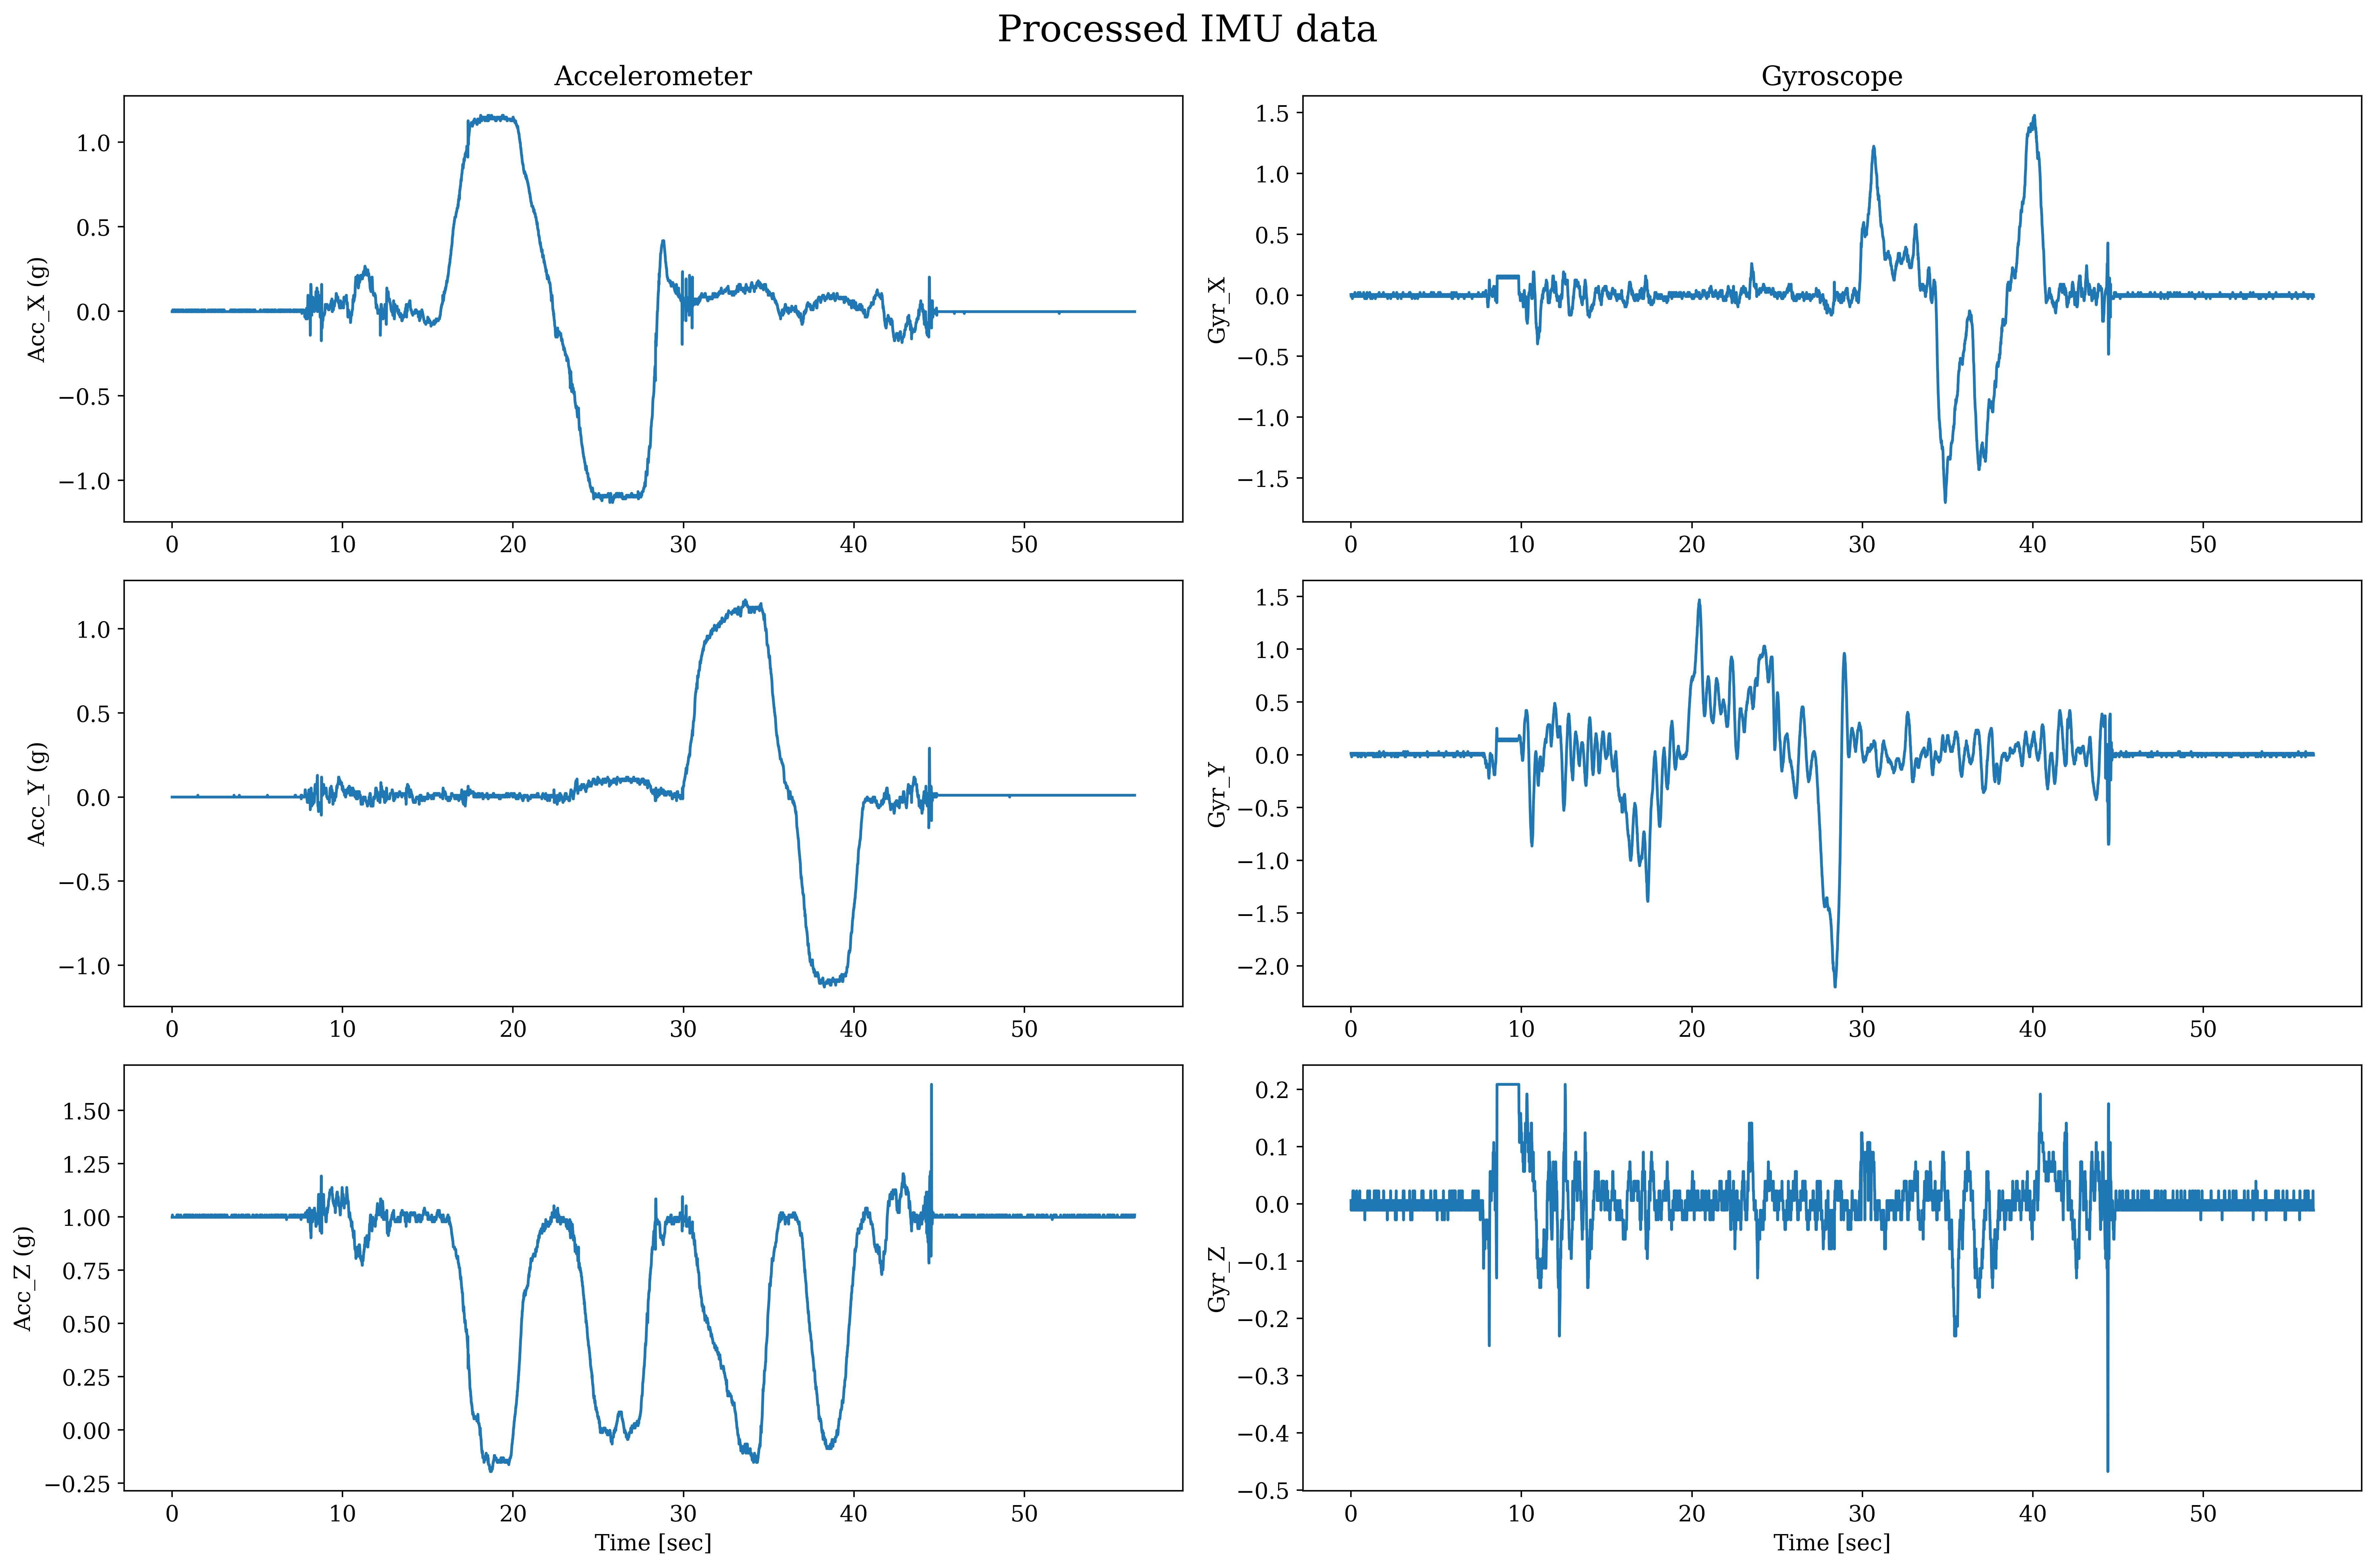

IMU data processing took: 2.4973411560058594 sec.



In [3]:
ts = tic()
sensitivity = np.array([300, 300, 300, 3.33, 3.33, 3.33])
plot_imu(imu_raw, title="Raw IMU data", path=f"../figures/raw_imu_{dataset_type}_{dataset}.pdf")
imu_processed = raw2physical(imu_raw, sensitivity, Vref=3300, bias_pre=100, copy=True)
plot_imu(imu_processed, title="Processed IMU data", path=f"../figures/processed_imu_{dataset_type}_{dataset}.pdf")
toc(ts, "IMU data processing")

## Integration

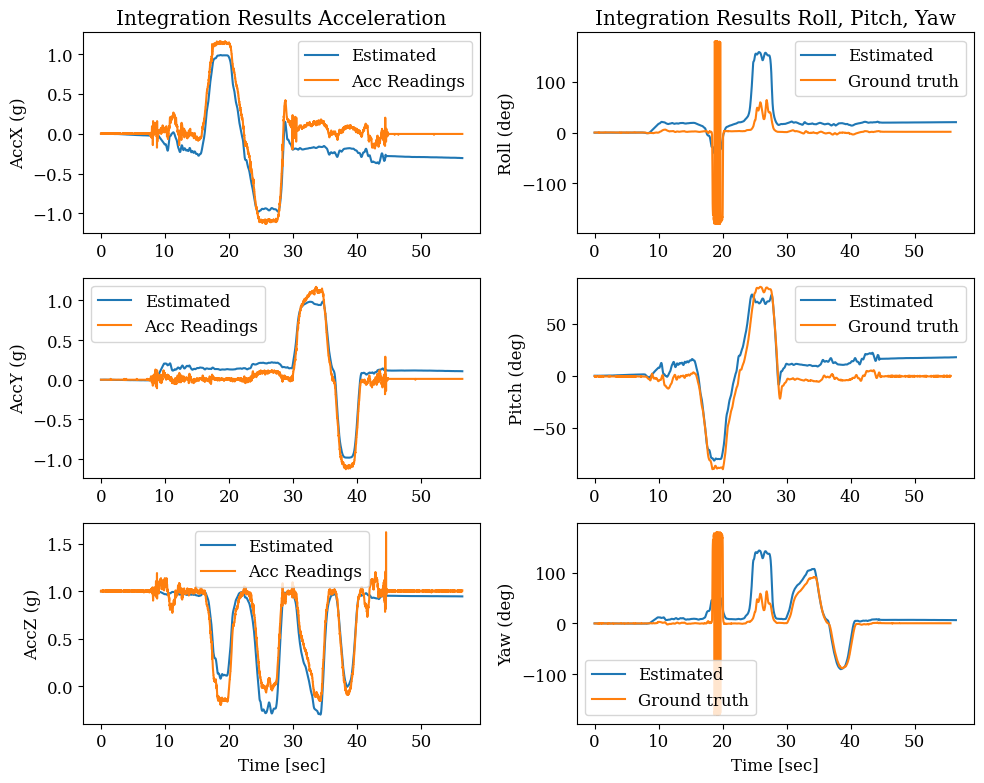

Integration took: 0.532804012298584 sec.



In [4]:
ts = tic()
rpy_estimated, q_estimated = rot_integrate(imu_processed)
acc_estimated = acc_body_frame(q_estimated)
rpy_ground_truth = vicon_roll_pitch_yaw(vicon_rot) if dataset_type == "trainset" else None
acc_rpy_plot(rpy_estimated, acc_estimated, rpy_ground_truth, \
             imu_processed[0:4], title="Integration Results ", path=f"../figures/integration_results_{dataset_type}_{dataset}.pdf")
toc(ts, "Integration")

## Optimization

Optimizing: 100%|██████████| 1000/1000 [00:07<00:00, 137.07it/s, loss=13.659967, motion loss=1.0586498, observation loss=12.601317]


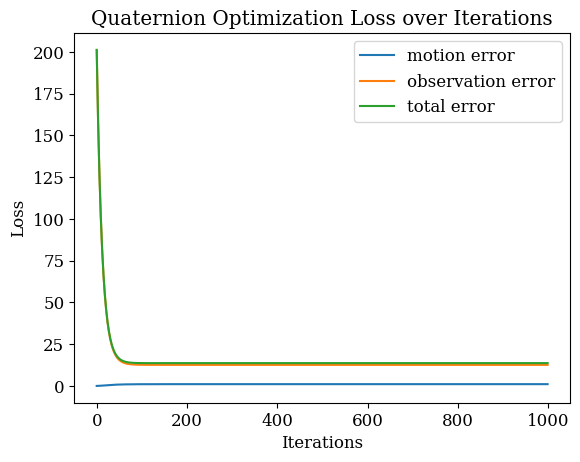

Optimization took: 7.447683095932007 sec.



In [5]:
ts = tic()
def loss_fn(q, gyro, acc):
    return motion_loss(q, gyro) + observation_loss(q, acc)
loss_fn_q = lambda q: loss_fn(q, imu_processed[4:], imu_processed[1:4])
q_optimized, loss_list = optimize(q_estimated, imu_processed, loss_fn_q, n_iter=1000, lr=1e-2)
loss_plot(loss_list, title="Quaternion Optimization", path=f"../figures/loss_{dataset_type}_{dataset}.pdf")
toc(ts, "Optimization")

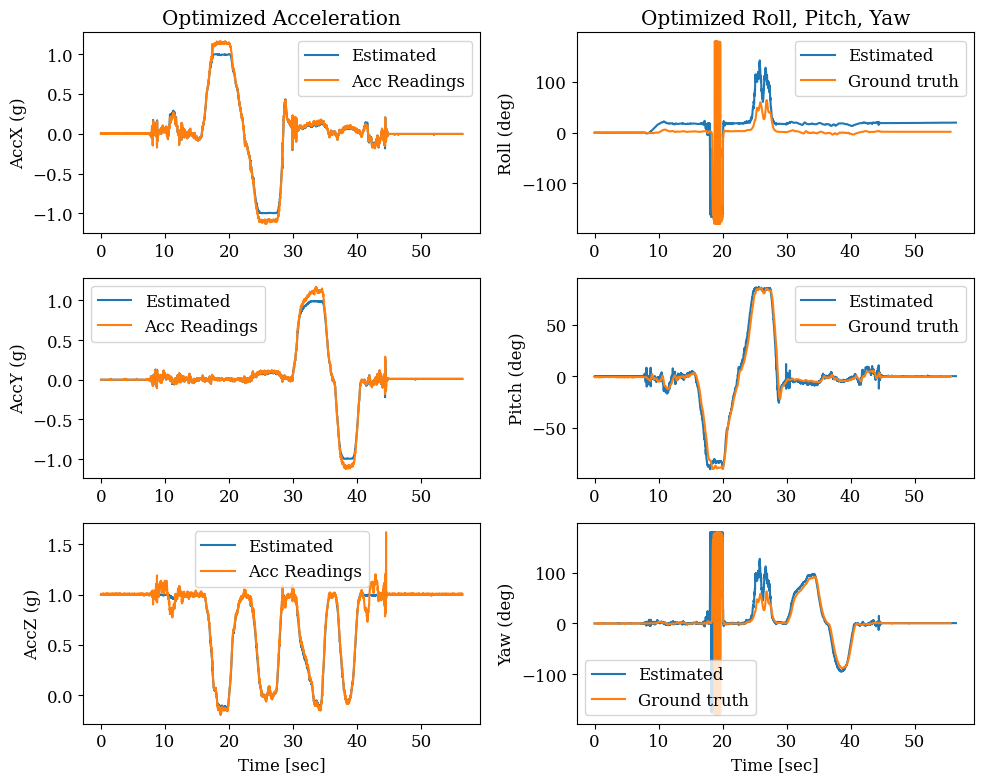

Optimized Results took: 0.476269006729126 sec.



In [6]:
ts = tic()
rpy_optimized = q2euler(q_optimized)
acc_optimized = acc_body_frame(q_optimized)
acc_rpy_plot(rpy_optimized, acc_optimized, rpy_ground_truth, \
             imu_processed[0:4], title="Optimized ", path=f"../figures/optimized_results_{dataset_type}_{dataset}.pdf")
toc(ts, "Optimized Results")

## Panorama

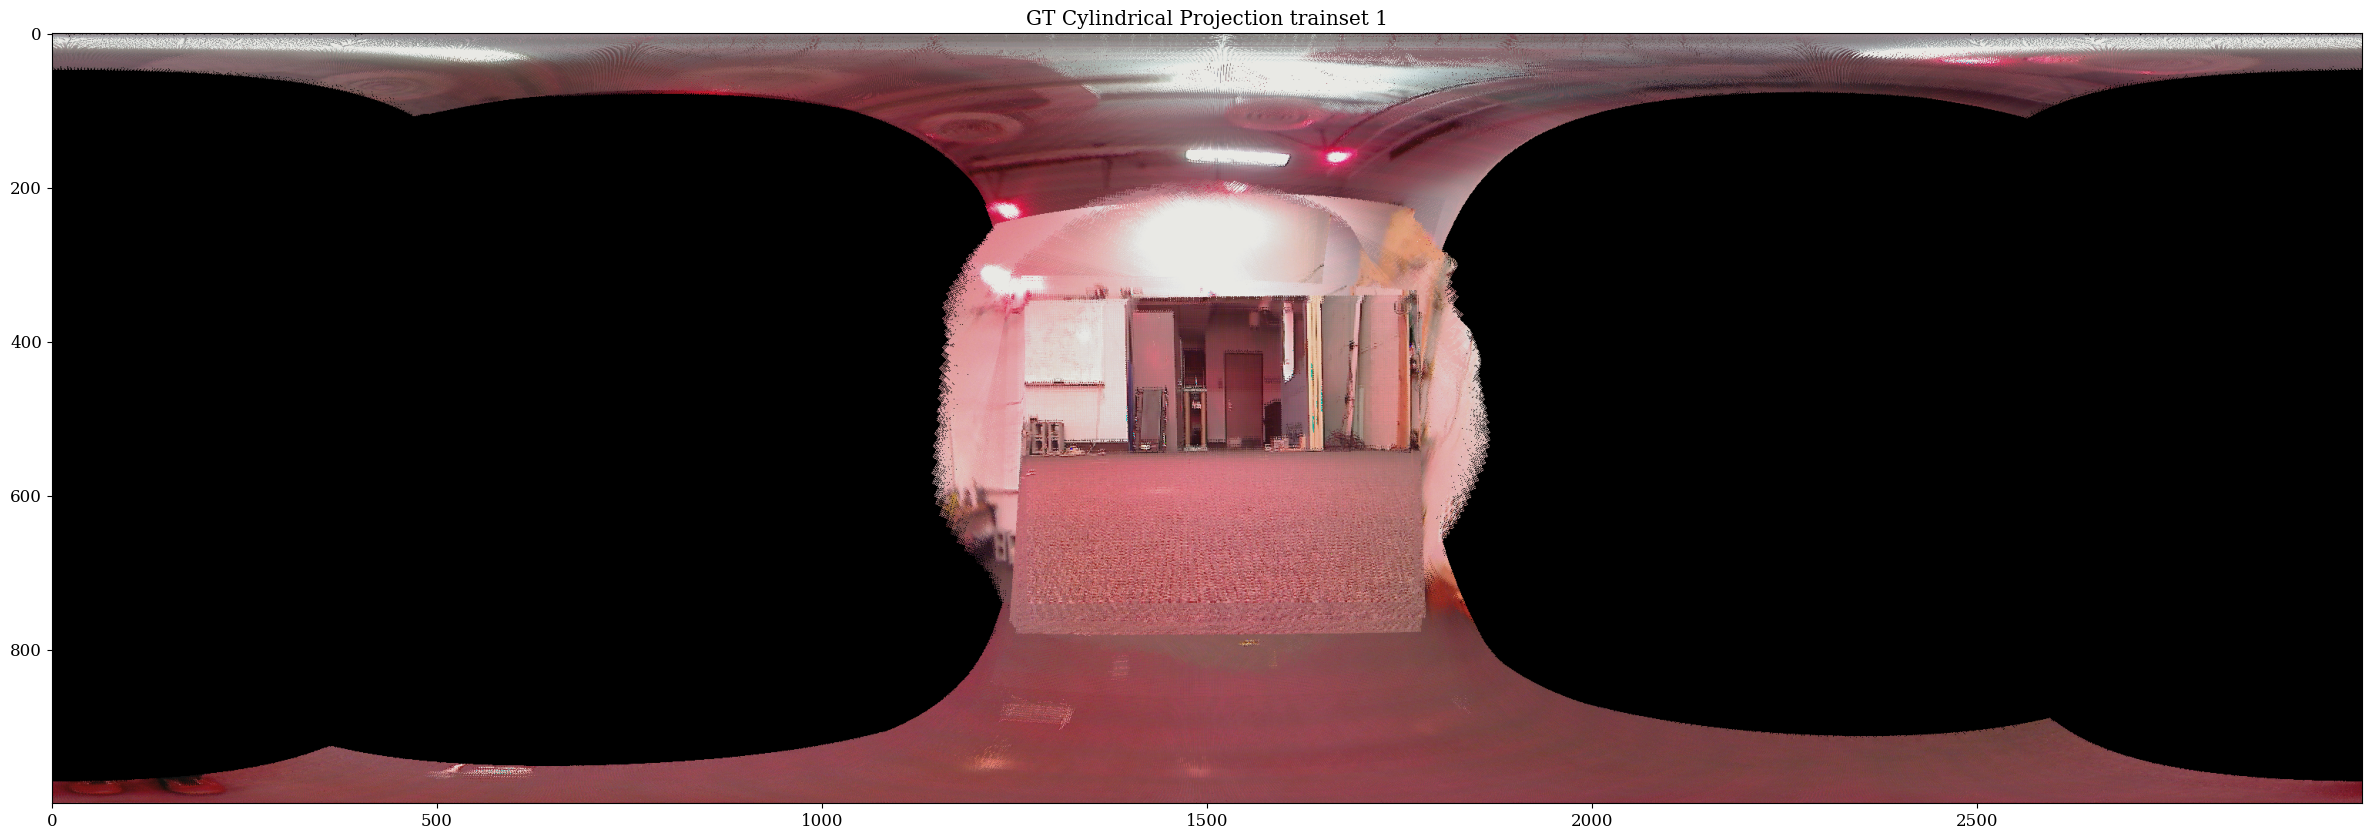

GT Cylinder Projection took: 10.608548879623413 sec.



In [7]:
if dataset_type == "trainset" and os.path.exists(cfile):
    ts = tic()
    # import open3d as o3d
    camd = read_data(cfile)
    camd = process_cam(camd, vicon_rot, start_time)
    coords, colors = images2pc(camd["cam"], (60, 45), camd["rots"])
    # pcd = o3d.geometry.PointCloud()
    # pcd.points = o3d.utility.Vector3dVector(coords.reshape(-1, 3))
    # pcd.colors = o3d.utility.Vector3dVector(colors.reshape(-1, 3) / 255)
    # o3d.visualization.draw_geometries([pcd])
    # plot_pc(coords, colors, title="Point Cloud")
    plot_cylinder(coords, colors, title=f"GT Cylindrical Projection {dataset_type} {dataset}", path=f"../figures/gt_cylinder_projection_{dataset_type}_{dataset}.pdf")
    toc(ts, "GT Cylinder Projection")

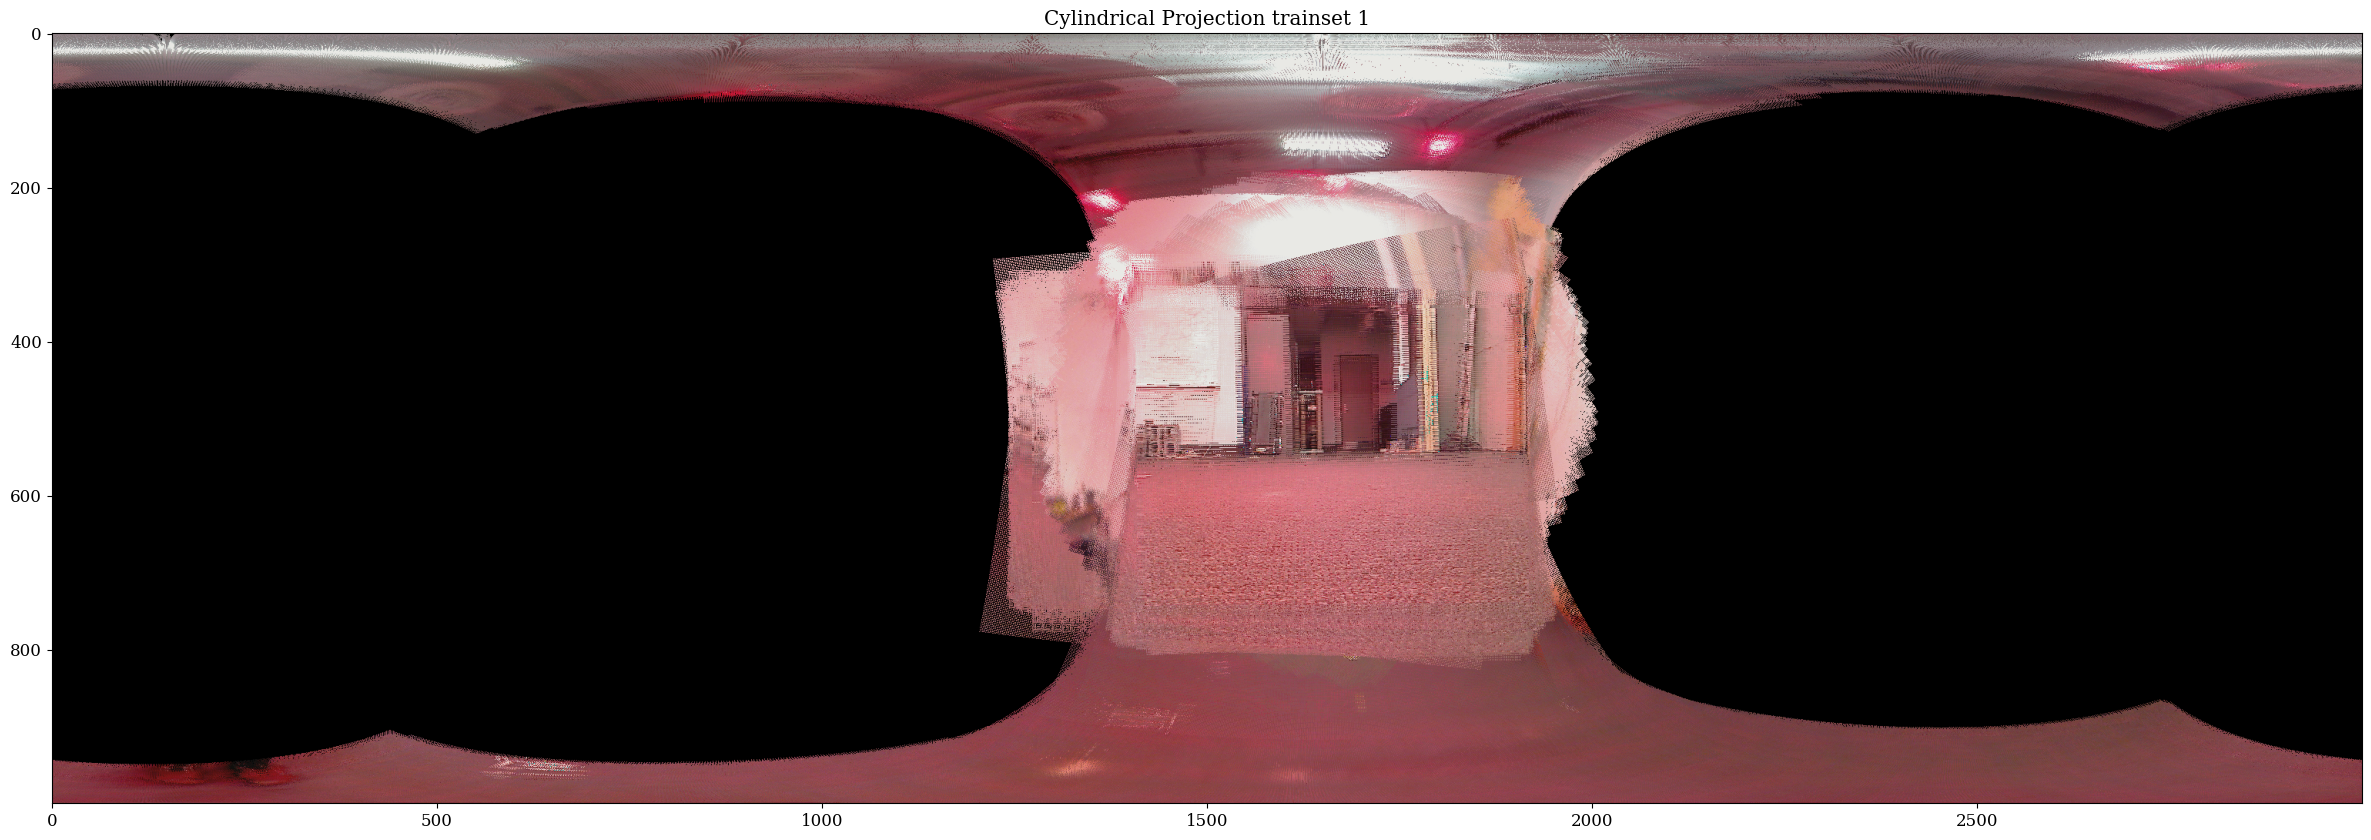

Cylinder Projection took: 11.38803505897522 sec.



In [8]:
if os.path.exists(cfile):
    ts = tic()
    camd = read_data(cfile)
    camd = process_cam(camd, q_optimized, start_time)
    coords, colors = images2pc(camd["cam"], (60, 45), camd["rots"])
    plot_cylinder(coords, colors, title=f"Cylindrical Projection {dataset_type} {dataset}", path=f"../figures/cylinder_projection_{dataset_type}_{dataset}.pdf")
    toc(ts, "Cylinder Projection")